# アウトプット
- Full-time, part-time, manergerのemployee数への、最小賃金値上げの影響を見る


| employee_type |avrage_number_before_treatment in NJ | avrage_number_after_treatment in NJ| difference_in_differences (by regression)|
|---------------|-------------------------------|------------------------------|------------------------------------------|
| full-time     | 50                            | 45                           | -5                                       |
| part-time     | 30                            | 28                           | -2                                       |

## 1. データの読み込みと前処理


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import seaborn as sns
import rdrobust
import rddensity
import causalpy as cp

import warnings
warnings.filterwarnings('ignore')

# 前処理

In [2]:
# public.datをdfとして読み込み
# カラム名はcodebookから取得
column_names = [
    'sheet', 'chain', 'co_owned', 'state',
    'southj', 'centralj', 'northj', 'pa1', 'pa2', 'shore',
    'ncalls', 'empft', 'emppt', 'nmgrs', 'wage_st',
    'inctime', 'firstinc', 'bonus', 'pctaff', 'meals',
    'open', 'hrsopen', 'psoda', 'pfry', 'pentree',
    'nregs', 'nregs11',
    'type2', 'status2', 'date2', 'ncalls2',
    'empft2', 'emppt2', 'nmgrs2', 'wage_st2',
    'inctime2', 'firstin2', 'special2', 'meals2',
    'open2r', 'hrsopen2', 'psoda2', 'pfry2', 'pentree2',
    'nregs2', 'nregs112'
]

df_org = pd.read_csv('data/input/njmin/public.dat', delim_whitespace=True, header=None, names=column_names)


In [3]:
df = df_org.copy()

float_cols = ['empft', 'emppt', 'nmgrs', 'empft2', 'emppt2', 'nmgrs2']
for col in float_cols:
    df[col] = df[col].str.replace('.', '0.0').astype(float)
df['empall'] = df['empft'] + df['emppt'] + df['nmgrs']
df['empall2'] = df['empft2'] + df['emppt2'] + df['nmgrs2']

In [4]:
df_org['state'].value_counts()

state
1    331
0     79
Name: count, dtype: int64

# 可視化

In [5]:
def plot_distribution(df, X_cols, t_col):
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))
    axs = axs.flatten()
    for i, col in enumerate(X_cols):
        ax = axs[i]
        sns.histplot(data=df, x=col, hue=t_col, stat='density', common_norm=False, ax=ax, alpha=0.5)
        # 点で平均を表示
        ax.scatter(df.loc[df[t_col] == 1, col].mean(), 0, alpha=0.5, color='orange', s=100, zorder=5, label='Treated Mean')
        ax.scatter(df.loc[df[t_col] == 0, col].mean(), 0, alpha=0.5, color='blue', s=100, zorder=5, label='Treated Mean')
    plt.tight_layout()

In [6]:
df_aggr = df.pivot_table(index=['state'], values=['empft', 'empft2'], aggfunc=['count', 'mean'])
df_aggr

count               mean           
      empft empft2       empft     empft2
state                                    
0        79     79  100.383544  73.420886
1       331    331   75.743505  81.753776

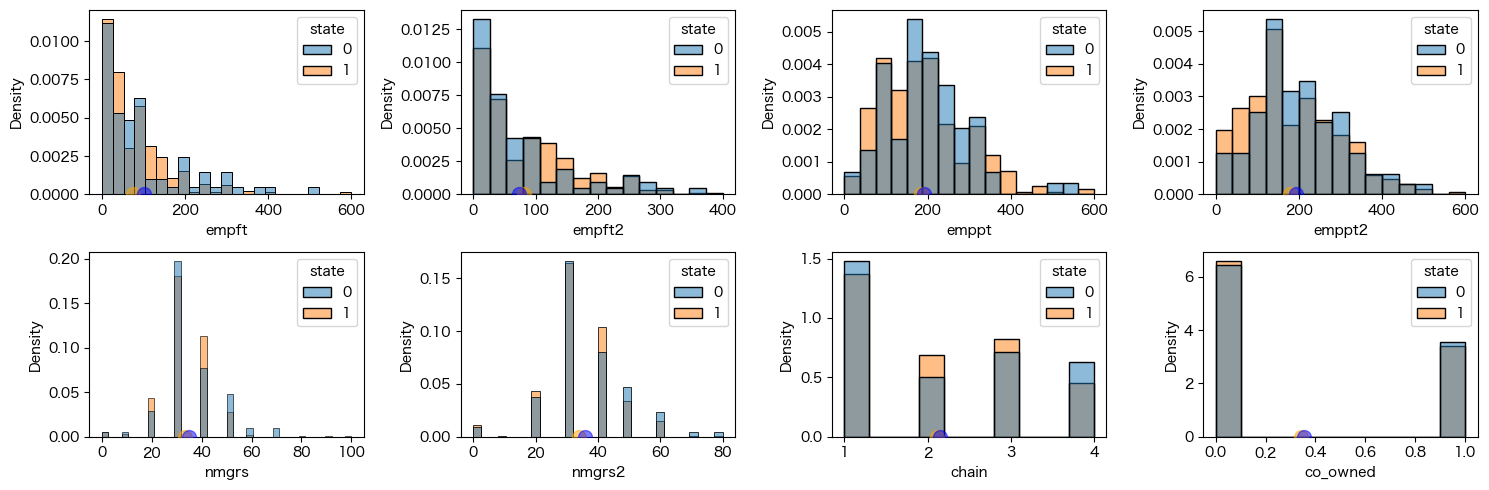

In [7]:
plot_cols = ['empft', 'empft2', 'emppt', 'emppt2', 'nmgrs', 'nmgrs2', 'chain', 'co_owned',]
for col in plot_cols:
    df[col] = df[col].astype(int)
plot_distribution(df, plot_cols, 'state') 

# DID

- 下記の回帰を実施する
```math
y = \beta_0 + \beta_1 \text{group} + \beta_2 \text{post\_treatment} + \beta_3 (\text{group} \times \text{post\_treatment}) + \epsilon
```

In [8]:
id_vars = ['sheet']
df_for_did = df.copy()
# empftとempft2を縦持ちにする。empftには、post_treatmentを0、empft2には1を割り当てる
# df_for_did = pd.melt(df_for_did, id_vars=id_vars, value_vars=['empft', 'empft2'], var_name='time', value_name='empft_')
df_for_did = pd.concat([
    df_for_did[['sheet', 'empft', 'emppt', 'nmgrs', 'empall']].assign(post_treatment=0),
    df_for_did[['sheet', 'empft2', 'emppt2', 'nmgrs2', 'empall2']].rename(columns=lambda x: x.replace('2', '')).assign(post_treatment=1)
])

df_for_did = df_for_did.merge(
    df[['sheet', 'chain', 'co_owned', 'state']],
    on='sheet',
    how='inner'
)

# df_for_did['post_treatment'] = np.where(df_for_did['time'] == 'empft2', 1, 0)
df_for_did['state_x_post_treatment'] = df_for_did['state'] * df_for_did['post_treatment']
df_for_did.head()

,sheet,empft,emppt,nmgrs,empall,post_treatment,chain,co_owned,state,state_x_post_treatment
0,46,300,150,30,480.0,0,1,0,0,0
1,49,60,60,40,160.1,0,2,0,0,0
2,506,30,70,20,120.0,0,2,1,0,0
3,56,200,200,40,440.0,0,4,1,0,0
4,61,60,260,50,370.0,0,4,1,0,0


In [9]:
y_col_list = ['empall', 'empft', 'emppt', 'nmgrs',]
df_result = pd.DataFrame(columns=['employee_type', 'avrage_number_before_treatment in NJ', 'avrage_number_after_treatment in NJ', 'difference_in_differences (by regression)', 'p_value'])
for y_col in y_col_list:
    # OLSによるDID推定
    # データ型を数値型に変換
    X = sm.add_constant(df_for_did[['state', 'post_treatment', 'state_x_post_treatment', 'chain', 'co_owned']].astype(float))
    y = df_for_did[y_col].astype(float)

    model = sm.OLS(y, X)
    results = model.fit()
    # print(results.summary())

    df_result = pd.concat([df_result, pd.DataFrame({
        'employee_type': [y_col],
        'avrage_number_before_treatment in NJ': [df_for_did.loc[(df_for_did['state'] == 1) & (df_for_did['post_treatment'] == 0), y_col].mean()],
        'avrage_number_after_treatment in NJ': [df_for_did.loc[(df_for_did['state'] == 1) & (df_for_did['post_treatment'] == 1), y_col].mean()],
        'difference_in_differences (by regression)': [results.params['state_x_post_treatment']],
        'p_value': [results.pvalues['state_x_post_treatment']]
    })], ignore_index=True)
df_result

,employee_type,avrage_number_before_treatment in NJ,avrage_number_after_treatment in NJ,difference_in_differences (by regression),p_value
0,empall,293.470873,294.431325,24.212952,0.284620
1,empft,75.572289,81.536145,32.213855,0.026910
2,emppt,184.518072,178.975904,-7.417169,0.689188
3,nmgrs,33.373494,33.915663,-0.582831,0.771780


In [10]:
df_result.to_clipboard(index=False)

# SC
モデル

```math
Y_{0t} = \sum_{i=1}^{N} w_i Y_{it} + \epsilon_{t}

```


- $Y_{it}$: 時点tにおける単位iのアウトカム変数
  - $i=0$: 処置群
  - $i=1,...,N$: 対照群
- $w_i$: 対照群iの重み
- $\epsilon_t$: 誤差項

In [11]:
df

,sheet,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,...,meals2,open2r,hrsopen2,psoda2,pfry2,pentree2,nregs2,nregs112,empall,empall2
0,46,1,0,0,0,0,0,1,0,0,...,2,6.50,16.50,1.03,.,0.94,4,4,480.0,410.05
1,49,2,0,0,0,0,0,1,0,0,...,2,10.00,13.00,1.01,0.89,2.35,4,4,160.1,190.00
2,506,2,1,0,0,0,0,1,0,0,...,1,11.00,11.00,0.95,0.74,2.33,4,3,120.0,140.00
3,56,4,1,0,0,0,0,1,0,0,...,2,10.00,12.00,0.92,0.79,0.87,2,2,440.0,380.00
4,61,4,1,0,0,0,0,1,0,0,...,2,10.00,12.00,1.01,0.84,0.95,2,2,370.0,370.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,423,2,1,1,0,0,1,0,0,0,...,1,11.00,11.00,1.05,0.84,2.32,3,2,140.0,250.05
406,424,2,1,1,0,0,1,0,0,0,...,1,11.00,14.00,1.05,0.94,2.32,5,3,120.1,190.00
407,426,3,1,1,0,0,1,0,0,0,...,2,6.00,18.00,1.11,1.05,1.05,6,5,410.0,330.00
408,427,4,0,1,0,0,1,0,0,0,...,2,10.50,12.50,1.11,1.09,2.07,2,2,180.0,380.00


In [12]:
df_temp = df.copy()

y_col_list = ['empall', 'empft', 'emppt', 'nmgrs']
df_result_sc = pd.DataFrame(columns=['employee_type', 'avg_before_t in NJ', 'avg_before_t sc', 'avg_after_t in NJ', 'avg_after_t sc', 'causal_effect (by SC)'])

for y_col in y_col_list:
    # 対照群と処置群のデータを準備
    y_col_after = y_col + '2' if y_col != 'empall' else 'empall2'
    
    df_for_sc_ctrl = df_temp.query('state==0')[[y_col, y_col_after]].T.reset_index(drop=True)
    df_for_sc_treated = df_temp.query('state==1')[[y_col, y_col_after]].mean().T.rename('actual').reset_index(drop=True)
    
    df_for_sc = df_for_sc_ctrl.merge(
        df_for_sc_treated,
        left_index=True,
        right_index=True,
    )
    
    # Synthetic Controlモデルの実行
    result = cp.SyntheticControl(
        df_for_sc,
        treatment_time=1,
        control_units=list(range(0, len(df_for_sc_ctrl.columns), 1)),
        treated_units=['actual'],
        model=cp.pymc_models.WeightedSumFitter(
            sample_kwargs={
                # 'draws': 10,  # サンプリング回数を指定(デフォルトは2000)
                # 'tune': 50,    # チューニング回数を指定(デフォルトは1000)
                'target_accept': 0.95,
                'random_seed': 42,
                'progressbar': False
            }
        )
    )
    
    # 結果の集計
    effect_summary = result.effect_summary()
    causal_effect = effect_summary.table.loc['average', 'mean']
    plot_data = result.get_plot_data()
    
    df_result_sc = pd.concat([df_result_sc, pd.DataFrame({
        'employee_type': [y_col],
        'avg_before_t in NJ': [plot_data.loc[0, 'actual']],
        'avg_before_t sc': [plot_data.loc[0, 'prediction']],
        'avg_after_t in NJ': [plot_data.loc[1, 'actual']],
        'avg_after_t sc': [plot_data.loc[1, 'prediction']],
        'causal_effect (by SC)': [causal_effect]
    })], ignore_index=True)

df_result_sc

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_

,employee_type,avg_before_t in NJ,avg_before_t sc,avg_after_t in NJ,avg_after_t sc,causal_effect (by SC)
0,empall,293.843897,294.038114,294.777039,289.119775,5.657264
1,empft,75.740181,75.974543,81.752266,70.418431,11.333835
2,emppt,184.712991,184.762489,179.093656,192.857641,-13.763985
3,nmgrs,33.383686,33.816890,33.927492,35.516316,-1.588823


In [13]:
result.get_plot_data()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,actual,prediction,pred_hdi_lower_94,pred_hdi_upper_94,impact,impact_hdi_lower_94,impact_hdi_upper_94
obs_ind,,,,,,,,,,,,,,,,,,,,,
0,30,40,20,40,50,50,30,50,50,20,...,30,30,40,33.383686,33.816890,32.556415,35.325888,-0.433204,-1.942202,0.827271
1,30,40,40,20,60,0,50,60,20,20,...,20,80,30,33.927492,35.516316,33.066386,38.248259,-1.588823,-4.320767,0.861106


In [14]:
df_result_sc.to_clipboard(index=False)


可視化中: empall

可視化中: empft

可視化中: emppt

可視化中: nmgrs


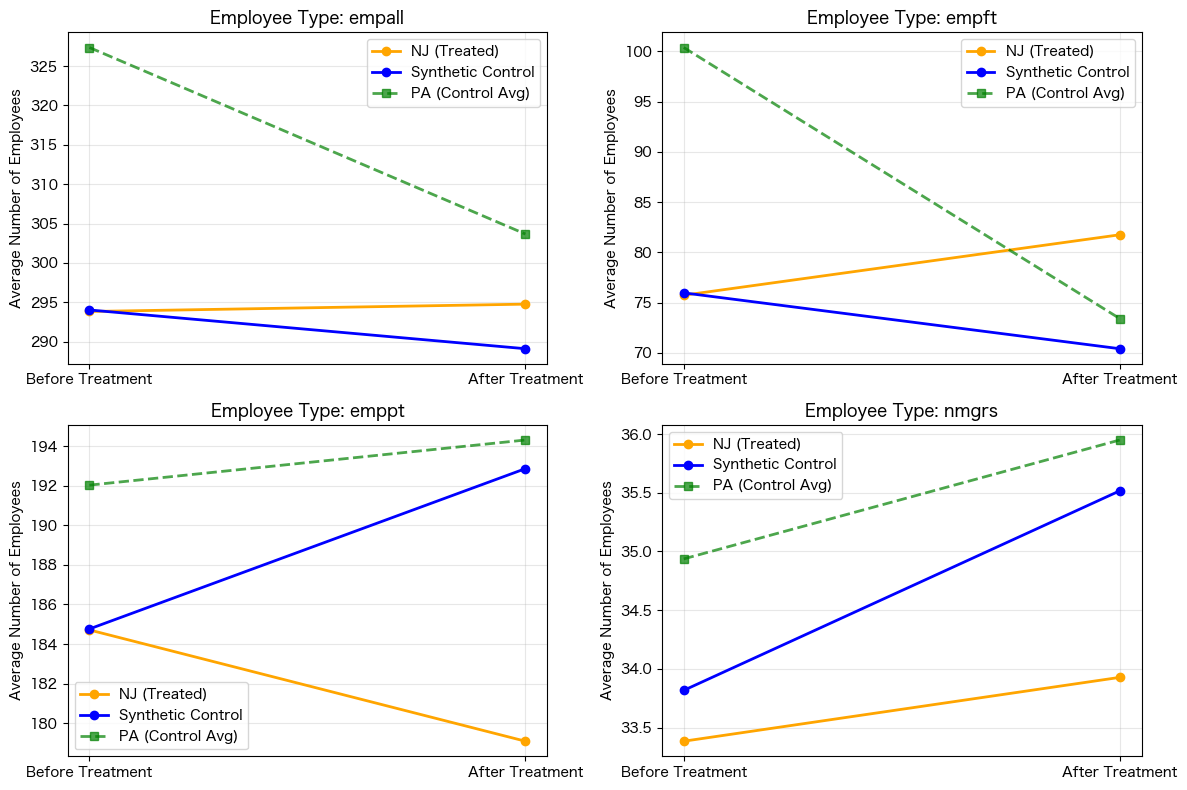

In [16]:
# result_scのavg_before_t in NJ, avg_before_t sc, avg_after_t in NJ, avg_after_t scを、折れ線グラフで可視化する
# 4列のaxを作って、そこにそれぞれのemployee_typeごとに折れ線グラフを描画する
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()
for idx, y_col in enumerate(y_col_list):
    print(f"\n可視化中: {y_col}")
    # df_result_scから該当する行を取得
    row = df_result_sc.query(f"employee_type == '{y_col}'").iloc[0]
    
    # 対照群（PA州）の平均値を計算
    y_col_after = y_col + '2' if y_col != 'empall' else 'empall2'
    ctrl_before = df_temp.query('state==0')[y_col].mean()
    ctrl_after = df_temp.query('state==0')[y_col_after].mean()
    
    ax = axs[idx]
    ax.plot(['Before Treatment', 'After Treatment'],
            [row['avg_before_t in NJ'], row['avg_after_t in NJ']],
            marker='o', label='NJ (Treated)', color='orange', linewidth=2)
    ax.plot(['Before Treatment', 'After Treatment'],
            [row['avg_before_t sc'], row['avg_after_t sc']],
            marker='o', label='Synthetic Control', color='blue', linewidth=2)
    ax.plot(['Before Treatment', 'After Treatment'],
            [ctrl_before, ctrl_after],
            marker='s', label='PA (Control Avg)', color='green', linewidth=2, linestyle='--', alpha=0.7)
    ax.set_title(f'Employee Type: {y_col}')
    ax.set_ylabel('Average Number of Employees')
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# SC Placebo Test (RMSE比率による検定)

画像の方法に基づく検定：
- 対照群の各単位について、処置前後のRMSE比率を計算
- 実際の処置群のRMSE比率と比較
- 処置群のRMSE比率が対照群の分布の中で有意に大きいかを確認

In [ ]:
def calculate_rmse_ratio(actual_values, predicted_values, treatment_time):
    """
    処置前後のRMSE比率を計算
    
    Parameters:
    -----------
    actual_values : array-like
        実際の値
    predicted_values : array-like
        予測値
    treatment_time : int
        処置が行われた時点のインデックス
    
    Returns:
    --------
    float : RMSE比率（処置後/処置前）
    """
    # 予測誤差の二乗
    squared_errors = (actual_values - predicted_values) ** 2
    
    # 処置前のRMSE
    pre_rmse = np.sqrt(np.mean(squared_errors[:treatment_time]))
    
    # 処置後のRMSE
    post_rmse = np.sqrt(np.mean(squared_errors[treatment_time:]))
    
    # RMSE比率
    if pre_rmse == 0:
        return np.inf
    
    return post_rmse / pre_rmse


def placebo_test_sc(df, y_col, treatment_time=1, n_ctrl_units=None):
    """
    Synthetic Controlのプラセボ検定を実施
    
    Parameters:
    -----------
    df : DataFrame
        分析用データ（state列を含む）
    y_col : str
        アウトカム変数名
    treatment_time : int
        処置が行われた時点のインデックス
    n_ctrl_units : int
        使用する対照群の数（Noneの場合は全て）
    
    Returns:
    --------
    dict : 検定結果
    """
    y_col_after = y_col + '2' if y_col != 'empall' else 'empall2'
    
    # 対照群と処置群のデータを準備
    df_ctrl = df.query('state==0')[[y_col, y_col_after]].T.reset_index(drop=True)
    df_treated = df.query('state==1')[[y_col, y_col_after]].mean().T.reset_index(drop=True)
    
    if n_ctrl_units is not None:
        df_ctrl = df_ctrl.iloc[:, :n_ctrl_units]
    
    n_controls = len(df_ctrl.columns)
    
    # 実際の処置群のSCを実行
    df_for_sc_treated = df_ctrl.copy()
    df_for_sc_treated['actual'] = df_treated.values
    
    result_treated = cp.SyntheticControl(
        df_for_sc_treated,
        treatment_time=treatment_time,
        control_units=list(range(n_controls)),
        treated_units=['actual'],
        model=cp.pymc_models.WeightedSumFitter(
            sample_kwargs={
                'target_accept': 0.95,
                'random_seed': 42,
                'progressbar': False
            }
        )
    )
    
    plot_data_treated = result_treated.get_plot_data()
    rmse_ratio_treated = calculate_rmse_ratio(
        plot_data_treated['actual'].values,
        plot_data_treated['prediction'].values,
        treatment_time
    )
    
    # 各対照群をPlacebo処置群として扱う
    rmse_ratios_placebo = []
    
    for i in range(n_controls):
        # i番目の対照群を処置群として扱う
        control_indices = [j for j in range(n_controls) if j != i]
        
        if len(control_indices) < 2:  # 対照群が少なすぎる場合はスキップ
            continue
        
        # 列名をリセットしてインデックスの問題を回避
        df_for_placebo = df_ctrl.iloc[:, control_indices].copy().reset_index(drop=True)
        df_for_placebo.columns = list(range(len(control_indices)))
        df_for_placebo['placebo_treated'] = df_ctrl.iloc[:, i].values
        
        try:
            result_placebo = cp.SyntheticControl(
                df_for_placebo,
                treatment_time=treatment_time,
                control_units=list(range(len(control_indices))),
                treated_units=['placebo_treated'],
                model=cp.pymc_models.WeightedSumFitter(
                    sample_kwargs={
                        'target_accept': 0.95,
                        'random_seed': 42 + i,
                        'progressbar': False
                    }
                )
            )
            
            plot_data_placebo = result_placebo.get_plot_data()
            rmse_ratio_placebo = calculate_rmse_ratio(
                plot_data_placebo['placebo_treated'].values,
                plot_data_placebo['prediction'].values,
                treatment_time
            )
            
            if not np.isinf(rmse_ratio_placebo):
                rmse_ratios_placebo.append(rmse_ratio_placebo)
        except Exception as e:
            print(f"Error in placebo {i}: {str(e)}")
            continue
    
    # p値の計算：実際の処置群のRMSE比率を超える対照群の割合
    if len(rmse_ratios_placebo) > 0:
        p_value = np.mean([r >= rmse_ratio_treated for r in rmse_ratios_placebo])
    else:
        p_value = np.nan
    
    return {
        'rmse_ratio_treated': rmse_ratio_treated,
        'rmse_ratios_placebo': rmse_ratios_placebo,
        'p_value': p_value,
        'n_placebo': len(rmse_ratios_placebo)
    }

In [ ]:
# 各employee_typeについてPlacebo検定を実施
# 対照群の数を制限して計算を高速化（最初の20店舗のみ使用）
y_col_list = ['empall', 'empft', 'emppt', 'nmgrs']
df_result_sc_test = pd.DataFrame(columns=['employee_type', 'rmse_ratio_treated', 'mean_rmse_ratio_placebo', 'p_value', 'n_placebo'])

for y_col in y_col_list:
    print(f"\n処理中: {y_col}")
    
    # Placebo検定を実施（対照群を20に制限）
    test_result = placebo_test_sc(df_temp, y_col, treatment_time=1, n_ctrl_units=20)
    
    df_result_sc_test = pd.concat([df_result_sc_test, pd.DataFrame({
        'employee_type': [y_col],
        'rmse_ratio_treated': [test_result['rmse_ratio_treated']],
        'mean_rmse_ratio_placebo': [np.mean(test_result['rmse_ratios_placebo']) if len(test_result['rmse_ratios_placebo']) > 0 else np.nan],
        'p_value': [test_result['p_value']],
        'n_placebo': [test_result['n_placebo']]
    })], ignore_index=True)

df_result_sc_test

Initializing NUTS using jitter+adapt_diag...



処理中: empall


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 1063 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...


Error in placebo 0: '[0] not in index'
Error in placebo 1: '[1] not in index'
Error in placebo 2: '[2] not in index'
Error in placebo 3: '[3] not in index'
Error in placebo 4: '[4] not in index'
Error in placebo 5: '[5] not in index'
Error in placebo 6: '[6] not in index'
Error in placebo 7: '[7] not in index'
Error in placebo 8: '[8] not in index'
Error in placebo 9: '[9] not in index'
Error in placebo 10: '[10] not in index'
Error in placebo 11: '[11] not in index'
Error in placebo 12: '[12] not in index'
Error in placebo 13: '[13] not in index'
Error in placebo 14: '[14] not in index'
Error in placebo 15: '[15] not in index'
Error in placebo 16: '[16] not in index'
Error in placebo 17: '[17] not in index'
Error in placebo 18: '[18] not in index'
Error in placebo 19: '[19] not in index'
Error in placebo 20: '[20] not in index'
Error in placebo 21: '[21] not in index'
Error in placebo 22: '[22] not in index'
Error in placebo 23: '[23] not in index'
Error in placebo 24: '[24] not in in

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 654 draw iterations (4_000 + 2_616 draws total) took 54 seconds.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Initializing NUTS using jitter+adapt_diag...



処理中: empft


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


: 

: 

In [ ]:
# RMSE比率の分布を可視化
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axs = axs.flatten()

for idx, y_col in enumerate(y_col_list):
    print(f"\n可視化中: {y_col}")
    
    # Placebo検定を実施（再度実行して詳細な結果を取得、対照群を20に制限）
    test_result = placebo_test_sc(df_temp, y_col, treatment_time=1, n_ctrl_units=20)
    
    ax = axs[idx]
    
    # Placebo群のRMSE比率の分布
    if len(test_result['rmse_ratios_placebo']) > 0:
        ax.hist(test_result['rmse_ratios_placebo'], bins=15, alpha=0.6, label='Placebo (対照群)', color='blue')
    
    # 実際の処置群のRMSE比率
    ax.axvline(test_result['rmse_ratio_treated'], color='red', linestyle='--', linewidth=2, 
               label=f'実際の処置群 (NJ)\nRMSE比率={test_result["rmse_ratio_treated"]:.3f}')
    
    ax.set_xlabel('RMSE比率 (処置後/処置前)')
    ax.set_ylabel('頻度')
    ax.set_title(f'{y_col}\np値={test_result["p_value"]:.3f}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 検定結果の解釈

- **RMSE比率（処置後/処置前）**: 1より大きいほど、処置後の予測誤差が大きい
- **p値**: 実際の処置群のRMSE比率が、Placebo群（対照群）のRMSE比率分布の中でどの程度極端かを示す
  - p値が小さい（例: < 0.05）ほど、処置の効果が統計的に有意
  - 画像の説明通り、「処置群のRMSEを超える対照群の数が少ないほど、処置の効果が大きい」